In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.container { 
    width: 100% !important;
}
</style>
"""))

In [3]:
import torch
from torch import nn, Tensor
from model.fuzzy_layer import FuzzyUnsignedConjunction, FuzzyUnsignedDisjunction, FuzzyNumKeepup, keepidx, fuzzy_dropup
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, DrasticLogic, SchweizerSklarLogic
from model.fuzzy_layer import FuzzyParam
from model.bool_logic import BoolLogic
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from util import shuffle

logic = BoolLogic()
flogic = ProductLogic()

In [4]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class WeightedDataset(Dataset):
    def __init__(self, N, D, K):
        super().__init__()
        self.samples = torch.zeros((N, D), dtype=torch.bool)
        self.samples[:,:K] = True
        self.samples = shuffle(self.samples, dim=-1)
        
    def __len__(self):
        return self.samples.size(0)
        
    def __getitem__(self, idx):
        return self.samples[idx]

class BinaryDataset(Dataset):
    def __init__(self, shape, N):
        self.samples = torch.distributions.bernoulli.Bernoulli(
            0.5
        ).sample(
            torch.Size([N, *shape])
        ).bool()
        
    def __len__(self):
        return self.samples.size(0)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [5]:
n_dims = 500

ds = BinaryDataset([n_dims], 10_000)
#ds = WeightedDataset(10_000, n_dims, n_dims - 10)
sampler = RandomSampler(ds, replacement=True, num_samples=300_000)
loader = DataLoader(ds, batch_size=64, sampler=sampler)

In [6]:
def rand_n_true(shape, N):
    falses = torch.zeros(shape, dtype=torch.bool)
    falses = falses.view(-1)
    falses[:N] = True
    falses = falses[torch.randperm(falses.size(0))]
    return falses.view(*shape)

In [7]:
weights = rand_n_true([n_dims], 30)

In [8]:
def train_conj(model, optim):

    ret = {
        "losses": [],
        "diffs": [],
    }
    
    for bs in tqdm(loader):
        bs = bs
        cjs = logic.conjoin(logic.implies(weights, bs), dim=1)
        cj_hats = cj_model(flogic.encode(bs)).squeeze()
        #loss = ((cjs.float() - cj_hats).abs()).mean()
        loss = (flogic.bin_xor(flogic.encode(cjs), cj_hats) ** 10).sum()
        ret["losses"].append(loss.item())
        ret["diffs"].append(flogic.bin_xor(weights.float(), model.weights.value().flatten()))

        optim.zero_grad()
        loss.backward()
        optim.step()

    ret["losses"] = torch.Tensor(ret["losses"])
    ret["diffs"] = torch.cat([t.unsqueeze(0) for t in ret["diffs"]], dim=0)
        
    return ret

In [9]:
cj_model = FuzzyUnsignedConjunction(in_features=n_dims, out_features=1, logic=flogic, keepn=30)
optim = torch.optim.Adam(cj_model.parameters(), lr=1e-2)

In [10]:
ret = train_conj(cj_model, optim)

  0%|          | 0/4688 [00:00<?, ?it/s]

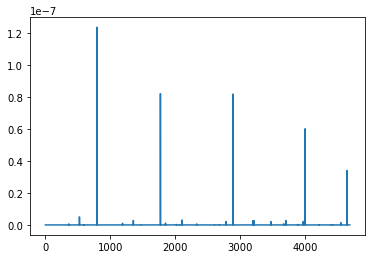

In [11]:
plt.plot(ret["losses"])

In [12]:
(cj_model.weights.value() > 0.5).flatten()

tensor([ True,  True,  True,  True, False,  True, False, False,  True, False,
         True,  True,  True, False,  True,  True,  True,  True,  True, False,
        False,  True, False,  True, False,  True,  True, False, False, False,
         True, False, False, False, False,  True,  True, False,  True,  True,
        False, False,  True, False,  True, False,  True,  True,  True, False,
        False,  True, False, False,  True, False, False, False,  True,  True,
         True,  True, False,  True,  True,  True, False,  True, False, False,
         True, False,  True, False,  True,  True, False,  True,  True, False,
        False, False,  True,  True,  True, False,  True, False,  True, False,
        False,  True,  True, False, False,  True, False, False,  True,  True,
        False,  True, False,  True, False,  True,  True, False, False, False,
        False,  True, False,  True, False, False, False,  True, False, False,
        False,  True, False,  True,  True, False, False,  True, 

In [13]:
weights

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, 

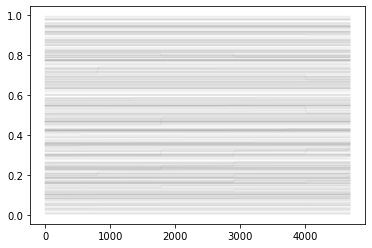

In [14]:
plt.plot(ret["diffs"].detach().numpy()[:], color="black", alpha=0.03)

In [15]:
ret["diffs"].shape

torch.Size([4688, 500])

In [16]:
print(ds)

In [17]:
ds.samples.shape

torch.Size([10000, 500])

In [18]:
xs = torch.rand((2,2))
idx = torch.Tensor([[0,1],[1,0]]).bool()
xs[idx] = (xs[idx] > 0.5).float()
xs

tensor([[0.3301, 0.0000],
        [0.0000, 0.1489]])

In [19]:
len(torch.ones((4,5)).shape)

2

In [20]:
xs = torch.arange(3) + torch.zeros(2,1)
idxs = keepidx((2,3), n=2, dim=1)
vals = xs[idxs]
vals = vals.reshape(*xs.shape[:-1], 2)
vals

tensor([[0., 2.],
        [1., 2.]])

In [21]:
take_rand_n(torch.arange(25).view(5,5), 3, dim=0)

NameError: name 'take_rand_n' is not defined

In [ ]:
torch.arange(25).view(5,5)